In [16]:
print(0)

0


# INSTALLING PYTHON LIBRARIES

In [17]:
pip install opencv-python opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
# used for directory manipulation and environment management

import numpy as np
# for numerical python

from PIL import Image
# opening, manipulating, and saving images

import cv2
# for image processing

from sklearn.cluster import KMeans
# clustering method (based on similarity)

from sklearn.svm import SVC
# simple ML model for plotting multi-dimensional plane for classification

from sklearn.preprocessing import StandardScaler
# to scale down the data

from sklearn.metrics import classification_report
# for presenting Accuracies, Precision, Recall, F1-score etc.

from sklearn.model_selection import KFold
# for model cross validation

from sklearn.manifold import TSNE
# for feature/dimensionality reduction (data trimming)

import matplotlib.pyplot as plt
# for plotting images

from sklearn.metrics import accuracy_score
# to print only the accuracy score

from sklearn.neighbors import KNeighborsClassifier
# knn classifier mode (euclidean distance)

# LOADING THE DATASET

In [19]:
folder_path = "/home/pratyushprasad/Desktop/GNR ASSIGNMENTS/assignment 1/Images"
# folder name where the images are stored

image_array = []
class_array = []
# creating empty image and class list

for class_name in os.listdir(folder_path):
    # looping through every class subfolder
    
    class_name_path = os.path.join(folder_path, class_name)    
    # location of the class folder
    
    if os.path.isdir(class_name_path):
        for image_file in os.listdir(class_name_path):
            # iterating through every imnage in the class folder
            
            image_path = os.path.join(class_name_path, image_file)
            # location of every image in the directory
            
            try:
                img = Image.open(image_path).convert("RGB")
                # opening the image
                
                img_resized = img.resize((256, 256))
                # resizing it to 256, 256 image size
                
                img_array = np.array(img_resized) / 255.0
                # scaling it 0 to 1
                
                image_array.append(img_array)
                class_array.append(class_name)
                # appending image and its class into the list
                
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

image_array = np.array(image_array)
class_array = np.array(class_array)
print(f"Loaded {len(image_array)} images with {len(class_array)} labels.")

Loaded 2100 images with 2100 labels.


# TRAIN TEST DATA SPLIT (80, 20)

In [20]:
len_datapoints = len(image_array)
# full image dataset size

len_train_datapoints = int(0.8 * len_datapoints)
len_test_datapoints = len_datapoints - len_train_datapoints
# length of train andtest datasets

list_indexes = np.arange(len_datapoints)
# length of full data

np.random.seed(100)
np.random.shuffle(list_indexes)
# shuffling trough the indexes to select random dataset

train_indexes = list_indexes[:len_train_datapoints]
test_indexes = list_indexes[len_train_datapoints:]

train_images = [image_array[i] for i in train_indexes]
train_labels = [class_array[i] for i in train_indexes]

test_images = [image_array[i] for i in test_indexes]
test_labels = [class_array[i] for i in test_indexes]
# train and test dataset

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
# converting list to array

print(f"Training set size: {len(train_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 1680
Test set size: 420


In [21]:
num_folds = 8
# K-Fold cross validation (70/10)

# FEATURE EXTRACTION USING SIFT 

In [22]:
codeword_counts = [10, 20, 50, 100]
# codeword count

def extract_sift_features(images):
    # function to extract the SIFT features
    
    sift = cv2.SIFT_create()
    all_descriptors = []
    descriptors_list = []
    # description and descriptor extraction into a list
    
    for img in images:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        # image to greyscale (0 to 255 pixel value instead of 0 to 1)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        # compute descriptors for each greyscale image
        
        if descriptors is not None:
            all_descriptors.extend(descriptors)
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(None)
    
    return np.array(all_descriptors), descriptors_list

all_descriptors, descriptors_list = extract_sift_features(train_images)

# MODEL TRAINING

In [23]:
def create_vocabulary(descriptors, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=100)
    # k means clustering methods
    
    kmeans.fit(descriptors)
    # fitting it on the descri[ptors section
    
    return kmeans

In [24]:
def create_histograms(descriptors_list, kmeans):
    # function to create histograms
    
    histograms = []
    # creating empty histogram list
    
    for descriptors in descriptors_list:
        if descriptors is not None:
            words = kmeans.predict(descriptors)
            histogram, _ = np.histogram(words, bins=range(kmeans.n_clusters + 1))
            # bag of words part
            
        else:
            histogram = np.zeros(kmeans.n_clusters)
        histograms.append(histogram)
    
    return np.array(histograms)

In [25]:
def evaluate_model_with_kfold_svm(histograms, labels, n_clusters):
    kf = KFold(n_splits=8, shuffle=True, random_state=100)
    # k fold cross validation 70 to 10 ratio on train dataset
    accuracies = []
    
    for train_idx, val_idx in kf.split(histograms):
        X_train, X_val = histograms[train_idx], histograms[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        # train and val inputs and labels
        
        # Train SVM classifier
        model = SVC(kernel='linear', random_state=100)
        model.fit(X_train, y_train)
        
        # Validate the model
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

In [26]:
def evaluate_model_with_kfold_knn(histograms, labels, n_clusters):
    kf = KFold(n_splits=8, shuffle=True, random_state=100)
    # k fold cross validation 70 to 10 ratio on train dataset
    accuracies = []
    
    for train_idx, val_idx in kf.split(histograms):
        X_train, X_val = histograms[train_idx], histograms[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        # train and val inputs and labels
        
        # Train KNN classifier
        model = KNeighborsClassifier(n_neighbors=n_clusters)
        model.fit(X_train, y_train)
        
        # Validate the model
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

In [27]:
results_svm = {}
results_knn = {}
for n_clusters in codeword_counts:
    kmeans = create_vocabulary(all_descriptors, n_clusters)
    histograms = create_histograms(descriptors_list, kmeans)
    
    accuracy_svm = evaluate_model_with_kfold_svm(histograms, train_labels, n_clusters)
    results_svm[n_clusters] = accuracy_svm
    print(f"Accuracy with svm {n_clusters} codewords: {accuracy_svm:.4f}")
    
    accuracy_knn = evaluate_model_with_kfold_knn(histograms, train_labels, n_clusters)
    results_knn[n_clusters] = accuracy_knn
    print(f"Accuracy with knn {n_clusters} codewords: {accuracy_knn:.4f}")

/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with svm 10 codewords: 0.5042
Accuracy with knn 10 codewords: 0.5137


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with svm 20 codewords: 0.5446
Accuracy with knn 20 codewords: 0.5268


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with svm 50 codewords: 0.6095
Accuracy with knn 50 codewords: 0.5387


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy with svm 100 codewords: 0.6381
Accuracy with knn 100 codewords: 0.4738


# MODEL EVALUATION

In [28]:
test_descriptors, test_descriptors_list = extract_sift_features(test_images)
test_results_knn = {}
for n_clusters in codeword_counts:
    print(f"\nEvaluating on test dataset with {n_clusters} codewords:")
    kmeans = create_vocabulary(all_descriptors, n_clusters)
    train_histograms = create_histograms(descriptors_list, kmeans)
    test_histograms = create_histograms(test_descriptors_list, kmeans)
    knn_model = KNeighborsClassifier(n_neighbors=n_clusters)
    knn_model.fit(train_histograms, train_labels)
    test_predictions = knn_model.predict(test_histograms)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_results_knn[n_clusters] = test_accuracy
    print(f"Test accuracy with {n_clusters} codewords: {test_accuracy:.4f}")


Evaluating on test dataset with 10 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 10 codewords: 0.5119

Evaluating on test dataset with 20 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 20 codewords: 0.5667

Evaluating on test dataset with 50 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 50 codewords: 0.5381

Evaluating on test dataset with 100 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 100 codewords: 0.4929


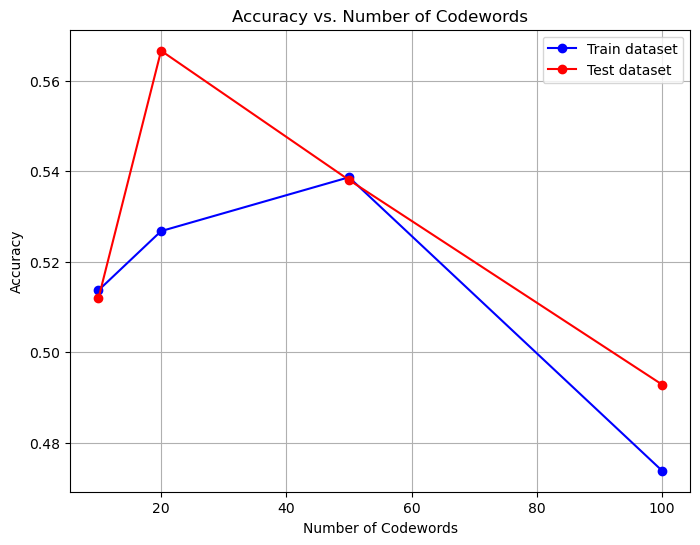

In [29]:
# THIS IS JUST RESULT COMPARISION OF MODEL ON = TRAIN DATASET 
plt.figure(figsize=(8, 6))
plt.plot(codeword_counts, [results_knn[n] for n in codeword_counts], marker='o', color = 'blue', label = "Train dataset")
plt.plot(codeword_counts, [test_results_knn[n] for n in codeword_counts], marker='o', color = 'red', label = "Test dataset")
plt.title("Accuracy vs. Number of Codewords")
plt.xlabel("Number of Codewords")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [30]:
test_descriptors, test_descriptors_list = extract_sift_features(test_images)
test_results_svm = {}
for n_clusters in codeword_counts:
    print(f"\nEvaluating on test dataset with {n_clusters} codewords:")
    kmeans = create_vocabulary(all_descriptors, n_clusters)
    train_histograms = create_histograms(descriptors_list, kmeans)
    test_histograms = create_histograms(test_descriptors_list, kmeans)
    svm_model = KNeighborsClassifier(n_neighbors=n_clusters)
    svm_model.fit(train_histograms, train_labels)
    test_predictions = svm_model.predict(test_histograms)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_results_svm[n_clusters] = test_accuracy
    print(f"Test accuracy with {n_clusters} codewords: {test_accuracy:.4f}")


Evaluating on test dataset with 10 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 10 codewords: 0.5095

Evaluating on test dataset with 20 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 20 codewords: 0.5643

Evaluating on test dataset with 50 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 50 codewords: 0.5333

Evaluating on test dataset with 100 codewords:


/home/pratyushprasad/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test accuracy with 100 codewords: 0.5000


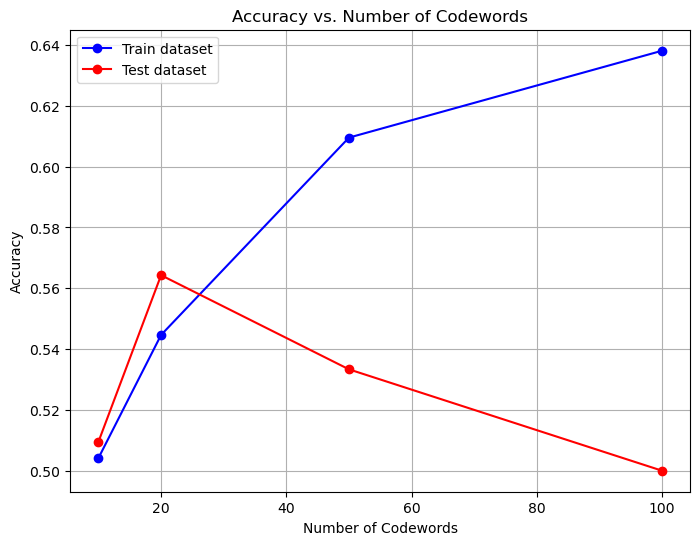

In [31]:
# THIS IS JUST RESULT COMPARISION OF MODEL ON = TRAIN DATASET 
plt.figure(figsize=(8, 6))
plt.plot(codeword_counts, [results_svm[n] for n in codeword_counts], marker='o', color = 'blue', label = "Train dataset")
plt.plot(codeword_counts, [test_results_svm[n] for n in codeword_counts], marker='o', color = 'red', label = "Test dataset")
plt.title("Accuracy vs. Number of Codewords")
plt.xlabel("Number of Codewords")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

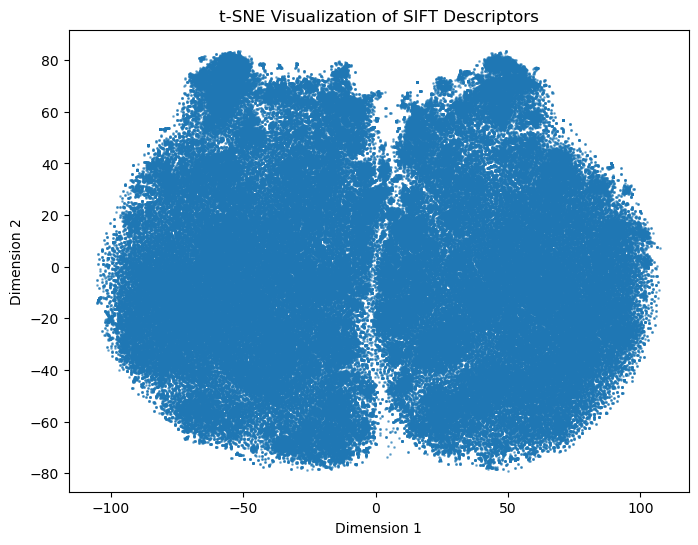

In [32]:
tsne = TSNE(n_components=2, random_state=100)
reduced_descriptors = tsne.fit_transform(test_descriptors)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_descriptors[:, 0], reduced_descriptors[:, 1], s=1, alpha=0.5)
plt.title("t-SNE Visualization of SIFT Descriptors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [33]:
print(0)

0
